In [1]:
from google.colab import files
uploaded = files.upload()

Saving MSN.csv to MSN.csv


In [2]:
#1. Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
# 2. Read file MSN
df = pd.read_csv('MSN.csv')
df["Price"] = df["Price"].str.replace(',', '').astype(float)
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1># 4. Split the data into training, testing arcording to 7:3

In [5]:
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 9s 160ms/step - loss: 0.1221
Epoch 2/100
13/13 [==============================] - 2s 163ms/step - loss: 0.0163
Epoch 3/100
13/13 [==============================] - 2s 159ms/step - loss: 0.0075
Epoch 4/100
13/13 [==============================] - 2s 161ms/step - loss: 0.0042
Epoch 5/100
13/13 [==============================] - 3s 231ms/step - loss: 0.0038
Epoch 6/100
13/13 [==============================] - 3s 218ms/step - loss: 0.0037
Epoch 7/100
13/13 [==============================] - 2s 158ms/step - loss: 0.0036
Epoch 8/100
13/13 [==============================] - 2s 160ms/step - loss: 0.0036
Epoch 9/100
13/13 [==============================] - 2s 158ms/step - loss: 0.0035
Epoch 10/100
13/13 [==============================] - 2s 158ms/step - loss: 0.0034
Epoch 11/100
13/13 [==============================] - 3s 233ms/step - loss: 0.0033
Epoch 12/100
13/13 [==============================] - 3s 218ms/step - loss: 0.0033
Epoch 13/100


In [11]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 [==============================] - 1s 65ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [13]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae_test = mean_absolute_error(ytest, y_pred)
mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print("Test MAE: ", mae_test)
print("Test MAPE: ", mape_test)

Testing RMSE: 2885.9136762200305
Test MAE:  2380.9332615858843
Test MAPE:  3.3113345802600884


In [14]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.38881022]
101
1 day input [0.27278593 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964
 0.25030062 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069
 0.26887544 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873
 0.23856915 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726
 0.24345726 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117
 0.26105446 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411
 0.30113697 0.34904046 0.36077193 0.3988992  0.37641389 0.36663766
 0.37836913 0.39987682 0.38032438 0.37641389 0.37054815 0.36566004
 0.36468242 0.37152578 0.37641389 0.34708522 0.33242089 0.3461076
 0.35197333 0.33437613 0.32655515 0.337309   0.32655515 0.32655515
 0.31189082 0.31189082 0.32753277 0.31775655 0.3109132  0.31189082
 0.26300971 0.25518873 0.26203209 0.25909922 0.26300971 0.24150202
 0.26300971 0.27474117 0.26594257 0.27376355 0.29136075 0.30406984
 0.30504746 0.31580131 0.30700271 0.30113697 0.30113697 0.29918173
 0.31482369 0.31677893 0.34708522 

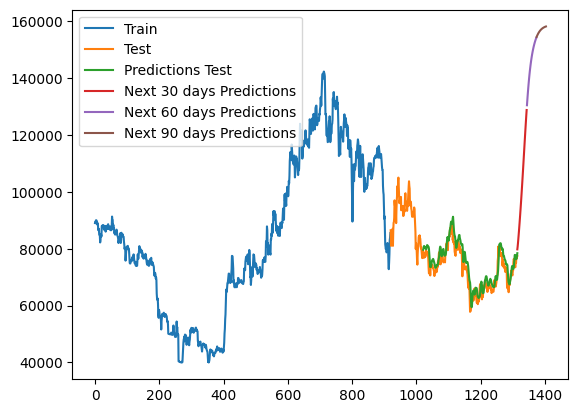

In [15]:
# 14. Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + time_step + 1 , stop=len(df1), step=1)
plt.plot(test_data_index, y_pred)

next_30_days_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1) + 29, stop=len(df1) + 59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1) + 59, stop=len(df1) + 89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train', 'Test', 'Predictions Test', 'Next 30 days Predictions', 'Next 60 days Predictions', 'Next 90 days Predictions'])
plt.show()

<h1># 4. Split the data into training, testing arcording to 8:2

In [16]:
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [17]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 10s 171ms/step - loss: 0.0596
Epoch 2/100
15/15 [==============================] - 2s 158ms/step - loss: 0.0106
Epoch 3/100
15/15 [==============================] - 2s 158ms/step - loss: 0.0049
Epoch 4/100
15/15 [==============================] - 2s 160ms/step - loss: 0.0039
Epoch 5/100
15/15 [==============================] - 3s 235ms/step - loss: 0.0037
Epoch 6/100
15/15 [==============================] - 3s 195ms/step - loss: 0.0037
Epoch 7/100
15/15 [==============================] - 2s 157ms/step - loss: 0.0036
Epoch 8/100
15/15 [==============================] - 2s 158ms/step - loss: 0.0035
Epoch 9/100
15/15 [==============================] - 2s 162ms/step - loss: 0.0033
Epoch 10/100
15/15 [==============================] - 3s 203ms/step - loss: 0.0033
Epoch 11/100
15/15 [==============================] - 3s 230ms/step - loss: 0.0033
Epoch 12/100
15/15 [==============================] - 2s 161ms/step - loss: 0.0030
Epoch 13/100

In [22]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

6/6 [==============================] - 1s 71ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [24]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae_test = mean_absolute_error(ytest, y_pred)
mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print("Test MAE: ", mae_test)
print("Test MAPE: ", mape_test)

Testing RMSE: 1774.2074712062267
Test MAE:  1315.4089023919757
Test MAPE:  1.927527181330669


In [25]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.3661234]
101
1 day input [0.27278593 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964
 0.25030062 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069
 0.26887544 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873
 0.23856915 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726
 0.24345726 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117
 0.26105446 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411
 0.30113697 0.34904046 0.36077193 0.3988992  0.37641389 0.36663766
 0.37836913 0.39987682 0.38032438 0.37641389 0.37054815 0.36566004
 0.36468242 0.37152578 0.37641389 0.34708522 0.33242089 0.3461076
 0.35197333 0.33437613 0.32655515 0.337309   0.32655515 0.32655515
 0.31189082 0.31189082 0.32753277 0.31775655 0.3109132  0.31189082
 0.26300971 0.25518873 0.26203209 0.25909922 0.26300971 0.24150202
 0.26300971 0.27474117 0.26594257 0.27376355 0.29136075 0.30406984
 0.30504746 0.31580131 0.30700271 0.30113697 0.30113697 0.29918173
 0.31482369 0.31677893 0.34708522 0

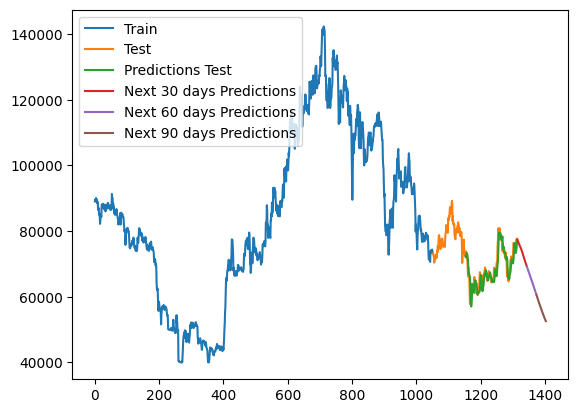

In [26]:
# 14. Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + time_step + 1 , stop=len(df1), step=1)
plt.plot(test_data_index, y_pred)

next_30_days_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1) + 29, stop=len(df1) + 59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1) + 59, stop=len(df1) + 89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train', 'Test', 'Predictions Test', 'Next 30 days Predictions', 'Next 60 days Predictions', 'Next 90 days Predictions'])
plt.show()

<h1># 4. Split the data into training, testing arcording to 9:1

In [27]:
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [28]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 11s 258ms/step - loss: 0.0337
Epoch 2/100
17/17 [==============================] - 3s 169ms/step - loss: 0.0070
Epoch 3/100
17/17 [==============================] - 3s 164ms/step - loss: 0.0040
Epoch 4/100
17/17 [==============================] - 3s 164ms/step - loss: 0.0035
Epoch 5/100
17/17 [==============================] - 4s 228ms/step - loss: 0.0034
Epoch 6/100
17/17 [==============================] - 3s 184ms/step - loss: 0.0034
Epoch 7/100
17/17 [==============================] - 3s 163ms/step - loss: 0.0033
Epoch 8/100
17/17 [==============================] - 3s 166ms/step - loss: 0.0031
Epoch 9/100
17/17 [==============================] - 3s 191ms/step - loss: 0.0030
Epoch 10/100
17/17 [==============================] - 4s 242ms/step - loss: 0.0029
Epoch 11/100
17/17 [==============================] - 3s 165ms/step - loss: 0.0028
Epoch 12/100
17/17 [==============================] - 3s 164ms/step - loss: 0.0027
Epoch 13/100

In [33]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 95ms/step


In [34]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [35]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae_test = mean_absolute_error(ytest, y_pred)
mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print("Test MAE: ", mae_test)
print("Test MAPE: ", mape_test)

Testing RMSE: 1449.9554722131627
Test MAE:  1179.239919354839
Test MAPE:  1.64594174957887


In [36]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.36708632]
101
1 day input [0.27278593 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964
 0.25030062 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069
 0.26887544 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873
 0.23856915 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726
 0.24345726 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117
 0.26105446 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411
 0.30113697 0.34904046 0.36077193 0.3988992  0.37641389 0.36663766
 0.37836913 0.39987682 0.38032438 0.37641389 0.37054815 0.36566004
 0.36468242 0.37152578 0.37641389 0.34708522 0.33242089 0.3461076
 0.35197333 0.33437613 0.32655515 0.337309   0.32655515 0.32655515
 0.31189082 0.31189082 0.32753277 0.31775655 0.3109132  0.31189082
 0.26300971 0.25518873 0.26203209 0.25909922 0.26300971 0.24150202
 0.26300971 0.27474117 0.26594257 0.27376355 0.29136075 0.30406984
 0.30504746 0.31580131 0.30700271 0.30113697 0.30113697 0.29918173
 0.31482369 0.31677893 0.34708522 

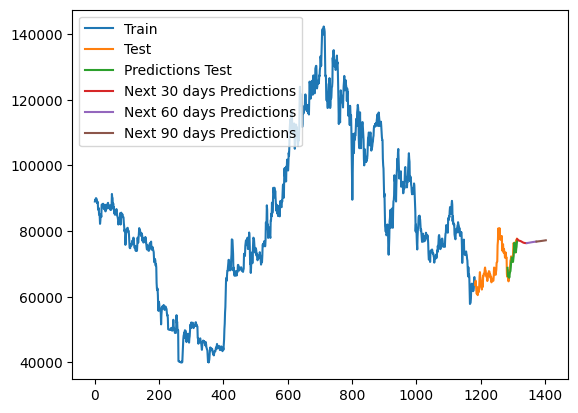

In [37]:
# 14. Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + time_step + 1 , stop=len(df1), step=1)
plt.plot(test_data_index, y_pred)

next_30_days_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1) + 29, stop=len(df1) + 59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1) + 59, stop=len(df1) + 89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train', 'Test', 'Predictions Test', 'Next 30 days Predictions', 'Next 60 days Predictions', 'Next 90 days Predictions'])
plt.show()